### RESULTS SAVED IN DIR: cifar_10_simple_resnet

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from scipy.stats import linregress
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Check for MPS (Metal Performance Shaders) backend
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

logging.info(f"Using device: {device}")

# Fixing seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define dataset loader
def load_dataset(dataset_name="MNIST", batch_size=32):
    if dataset_name == "MNIST":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    elif dataset_name == "CIFAR10":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset. Currently supported: 'MNIST', 'CIFAR10'.")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Define a simple fully connected neural network
class FullyConnectedNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

# Define a ResNet-like CNN
class SimpleResNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Corrected input size
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.nn.functional.avg_pool2d(x, 2)  # Output shape: (batch_size, 128, 16, 16)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Compute alignment metrics
def compute_alignment(matrix1, matrix2):
    norm1 = torch.norm(matrix1, p='fro')
    norm2 = torch.norm(matrix2, p='fro')
    alignment = torch.trace(matrix1 @ matrix2.T) / (norm1 * norm2)
    return alignment.item()

# Compute power-law exponents
def compute_power_law_exponent(eigenvalues):
    indices = np.arange(1, len(eigenvalues) + 1)
    slope, _, _, _, _ = linregress(np.log(indices), np.log(eigenvalues))
    return slope


def train_and_log_metrics(model, dataloader, optimizer, criterion, num_epochs=10):
    alignments = []
    eigenvalue_spectra = []
    rank_history = []
    gradient_noise_scales = []

    for epoch in range(num_epochs):
        logging.info(f"Epoch {epoch+1}/{num_epochs}")
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

        logging.info(f"Loss after epoch {epoch+1}: {loss.item()}")

        # Compute alignment metrics and eigenvalue spectra
        with torch.no_grad():
            for layer in model.children():
                if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                    weights = layer.weight
                    gradients = layer.weight.grad

                    # Flatten input data for covariance computation
                    if len(X.size()) > 2:
                        flattened_X = X.view(X.size(0), -1)
                    else:
                        flattened_X = X

                    # Compute covariance of input data on CPU
                    covariance_h = torch.cov(flattened_X.cpu().T)

                    # Flatten gradients consistently
                    if len(gradients.shape) > 2:
                        flattened_gradients = gradients.view(gradients.size(0), -1)
                    else:
                        flattened_gradients = gradients

                    # Compute gradient covariance on CPU
                    covariance_g = torch.cov(flattened_gradients.cpu().T)

                    # Ensure matrices have same dimensions for alignment
                    min_dim = min(covariance_h.size(0), covariance_g.size(0))
                    covariance_h = covariance_h[:min_dim, :min_dim]
                    covariance_g = covariance_g[:min_dim, :min_dim]

                    # Compute alignment
                    norm1 = torch.norm(covariance_h, p='fro')
                    norm2 = torch.norm(covariance_g, p='fro')
                    alignment = torch.trace(covariance_h @ covariance_g.T) / (norm1 * norm2)
                    alignments.append(alignment.item())

                    # Compute eigenvalues and other metrics on CPU
                    eigenvalues_h = torch.linalg.eigvalsh(covariance_h).numpy()
                    eigenvalue_spectra.append(eigenvalues_h)

                    rank = torch.linalg.matrix_rank(covariance_h).item()
                    rank_history.append(rank)

                    # Gradient noise scale
                    grad_norm = torch.norm(gradients)
                    noise_scale = grad_norm / (torch.norm(gradients, dim=1).mean())
                    gradient_noise_scales.append(noise_scale.item())

    return alignments, eigenvalue_spectra, rank_history, gradient_noise_scales

# Visualization functions (unchanged)
def plot_alignment(alignments):
    plt.plot(alignments)
    plt.title("Alignment Metrics Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Alignment")
    plt.show()

def plot_eigenvalues(eigenvalue_spectra):
    for epoch, eigvals in enumerate(eigenvalue_spectra):
        if epoch % 10 == 0:
            plt.plot(eigvals, label=f"Epoch {epoch}")
    plt.title("Eigenvalue Spectra Over Epochs")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.show()

def plot_rank_history(rank_history):
    plt.plot(rank_history)
    plt.title("Rank of Representations Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Rank")
    plt.show()

def plot_gradient_noise_scales(gradient_noise_scales):
    plt.plot(gradient_noise_scales)
    plt.title("Gradient Noise Scale Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Noise Scale")
    plt.show()

2025-02-02 18:49:55,337 - INFO - Using device: mps


### RUN 1

2025-02-01 03:31:04,564 - INFO - Using device: mps


Files already downloaded and verified
Files already downloaded and verified


2025-02-01 03:31:05,800 - INFO - Epoch 1/20
2025-02-01 03:31:21,864 - INFO - Loss after epoch 1: 0.7402336597442627
2025-02-01 03:31:31,290 - INFO - Epoch 2/20
2025-02-01 03:31:44,942 - INFO - Loss after epoch 2: 0.8934565782546997
2025-02-01 03:31:52,349 - INFO - Epoch 3/20
2025-02-01 03:32:05,962 - INFO - Loss after epoch 3: 0.7098011374473572
2025-02-01 03:32:13,269 - INFO - Epoch 4/20
2025-02-01 03:32:27,305 - INFO - Loss after epoch 4: 1.1317106485366821
2025-02-01 03:32:35,136 - INFO - Epoch 5/20
2025-02-01 03:32:49,307 - INFO - Loss after epoch 5: 0.6693913340568542
2025-02-01 03:32:57,160 - INFO - Epoch 6/20
2025-02-01 03:33:11,565 - INFO - Loss after epoch 6: 0.7455648183822632
2025-02-01 03:33:19,315 - INFO - Epoch 7/20
2025-02-01 03:33:33,172 - INFO - Loss after epoch 7: 0.6796900033950806
2025-02-01 03:33:41,323 - INFO - Epoch 8/20
2025-02-01 03:33:55,270 - INFO - Loss after epoch 8: 0.5080521106719971
2025-02-01 03:34:02,853 - INFO - Epoch 9/20
2025-02-01 03:34:16,766 - IN

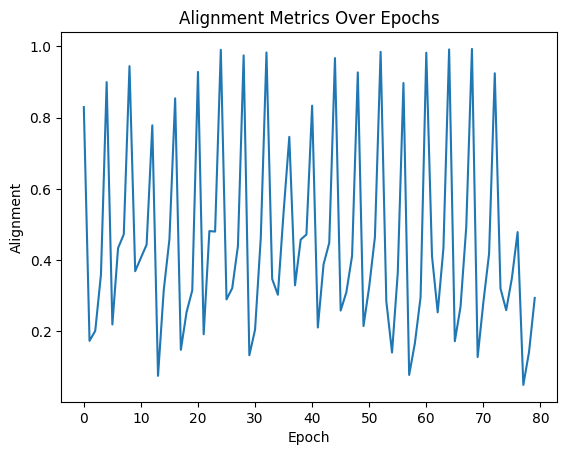

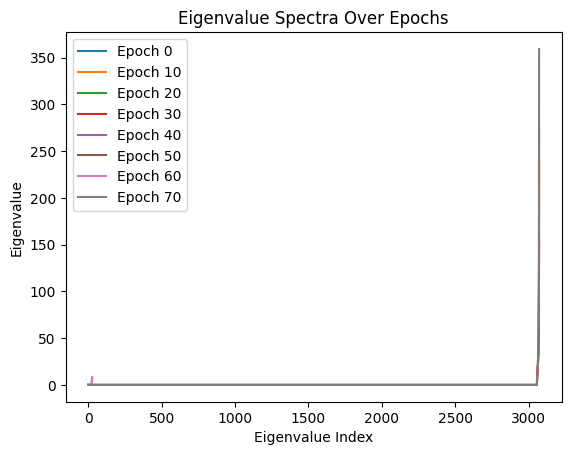

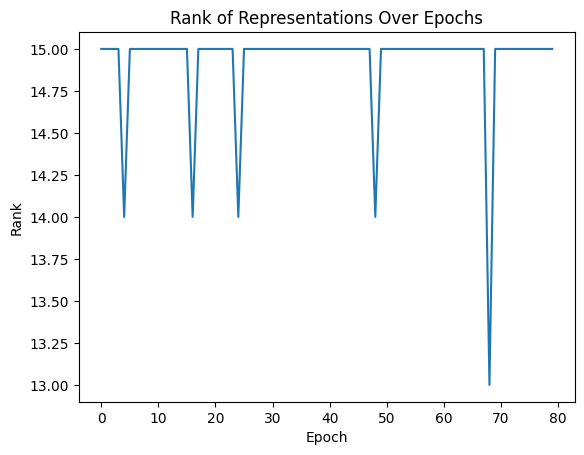

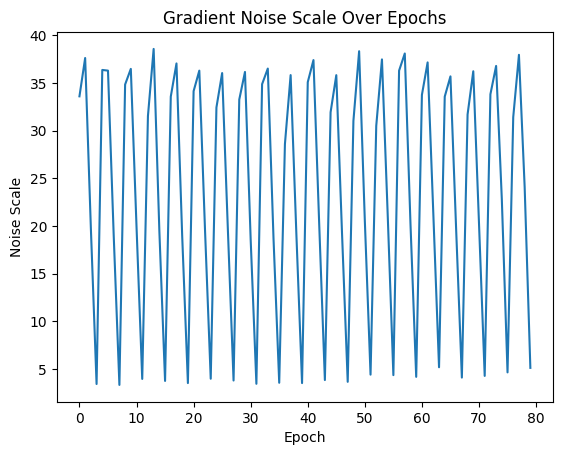

In [1]:
# Main script
if __name__ == "__main__":
    # Parameters
    dataset_name = "CIFAR10"  # Switch between "MNIST" and "CIFAR10"
    input_dim = 28 * 28 if dataset_name == "MNIST" else None
    hidden_dim = 128
    output_dim = 10
    batch_size = 64
    learning_rate = 0.01
    num_epochs = 20

    # Load dataset and model
    train_loader, test_loader = load_dataset(dataset_name, batch_size=batch_size)

    if dataset_name == "MNIST":
        model = FullyConnectedNet(input_dim, hidden_dim, output_dim).to(device)
    elif dataset_name == "CIFAR10":
        model = SimpleResNet(input_channels=3, num_classes=output_dim).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Train and log metrics
    alignments, eigenvalue_spectra, rank_history, gradient_noise_scales = train_and_log_metrics(
        model, train_loader, optimizer, criterion, num_epochs
    )

    # Plot results
    plot_alignment(alignments)
    plot_eigenvalues(eigenvalue_spectra)
    plot_rank_history(rank_history)
    plot_gradient_noise_scales(gradient_noise_scales)

### RUN 2

Files already downloaded and verified
Files already downloaded and verified


2025-02-02 18:56:30,027 - INFO - Epoch 1/20
2025-02-02 18:56:43,815 - INFO - Loss after epoch 1: 1.0398600101470947
2025-02-02 18:56:52,110 - INFO - Epoch 2/20
2025-02-02 18:57:05,547 - INFO - Loss after epoch 2: 1.0196185111999512
2025-02-02 18:57:12,883 - INFO - Epoch 3/20
2025-02-02 18:57:26,306 - INFO - Loss after epoch 3: 0.7288663387298584
2025-02-02 18:57:33,604 - INFO - Epoch 4/20
2025-02-02 18:57:47,022 - INFO - Loss after epoch 4: 0.9506994485855103
2025-02-02 18:57:54,518 - INFO - Epoch 5/20
2025-02-02 18:58:08,057 - INFO - Loss after epoch 5: 0.9255929589271545
2025-02-02 18:58:15,586 - INFO - Epoch 6/20
2025-02-02 18:58:29,174 - INFO - Loss after epoch 6: 0.8617416620254517
2025-02-02 18:58:36,812 - INFO - Epoch 7/20
2025-02-02 18:58:50,460 - INFO - Loss after epoch 7: 0.939171552658081
2025-02-02 18:58:57,272 - INFO - Epoch 8/20
2025-02-02 18:59:11,009 - INFO - Loss after epoch 8: 0.4958512783050537
2025-02-02 18:59:18,269 - INFO - Epoch 9/20
2025-02-02 18:59:31,767 - INF

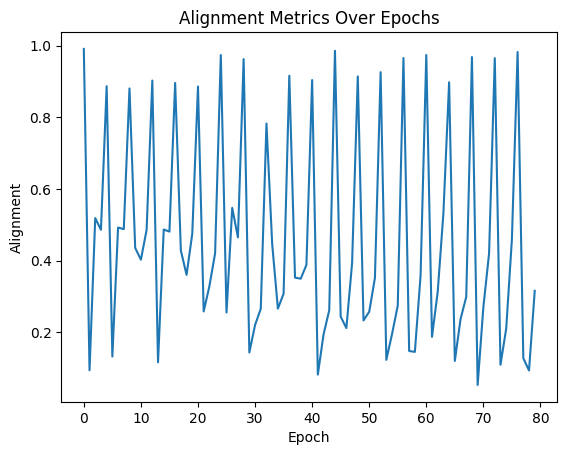

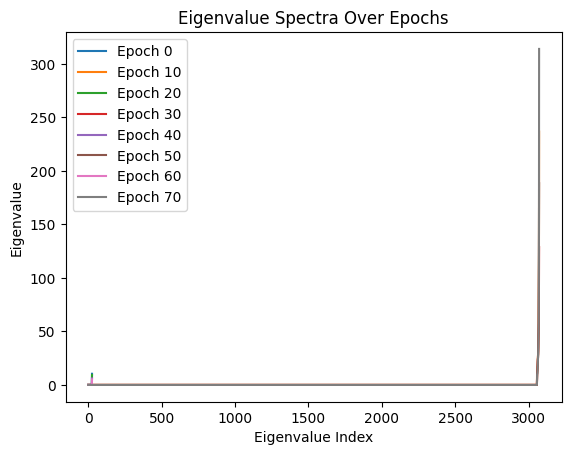

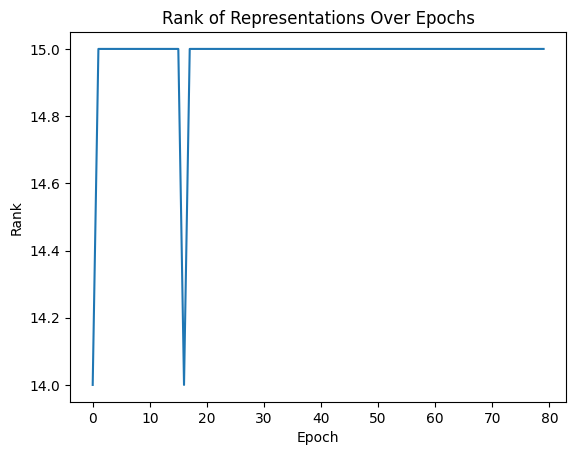

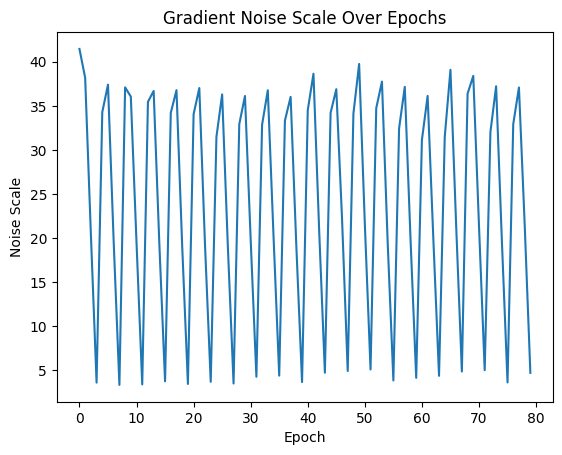

In [4]:
# Main script
if __name__ == "__main__":
    # Parameters
    dataset_name = "CIFAR10"  # Switch between "MNIST" and "CIFAR10"
    input_dim = 28 * 28 if dataset_name == "MNIST" else None
    hidden_dim = 128
    output_dim = 10
    batch_size = 64
    learning_rate = 0.01
    num_epochs = 20

    # Load dataset and model
    train_loader, test_loader = load_dataset(dataset_name, batch_size=batch_size)

    if dataset_name == "MNIST":
        model = FullyConnectedNet(input_dim, hidden_dim, output_dim).to(device)
    elif dataset_name == "CIFAR10":
        model = SimpleResNet(input_channels=3, num_classes=output_dim).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Train and log metrics
    alignments, eigenvalue_spectra, rank_history, gradient_noise_scales = train_and_log_metrics(
        model, train_loader, optimizer, criterion, num_epochs
    )

    # Plot results
    plot_alignment(alignments)
    plot_eigenvalues(eigenvalue_spectra)
    plot_rank_history(rank_history)
    plot_gradient_noise_scales(gradient_noise_scales)